# Cycle-by-cycle algorithm


Demonstration of the cycle-by-cycle approach.

In the last tutorial notebook, I described the conventional approach for analyzing time-varying
properties of neural oscillations, and in this notebook, we will go over our alternative approach.
The fundamental goal of this approach is to characterize neural oscillations directly in the time
domain. However, this is not straightforward because it attempts to extract the properties of the
oscillatory component, despite the large amount of noise. Specifically, there are two very difficult
problems:

1. What are the features of the oscillation? How do they vary over time?
2. During what times is the oscillation present?

The cycle-by-cycle approach deploys a few strategies to approach these questions. As its name
indicates, this algorithm segments the signal into individual cycles and then analyzes their
features separately from one another. Normally, some preprocessing is recommended to aid in
localizing peaks and troughs (eliminating high frequency power that mostly do not comprise the
oscillator of interest). Additionally, a burst detection approach is applied to define the segments
of the signal to be analyzed for their oscillatory properties.

During this process (as with all data analyses), it is important to be aware if the data is being
processed appropriately. As signal processing is complicated, it is very beneficial to visualize
the measured features along with the raw data to assure they make sense.

## 0. Preprocess signal

A crucial part of the cycle-by-cycle approach is the ability to localize the peaks and troughs of
the oscillation. Therefore, some preprocessing of the signal is often useful in order to make
these extrema more apparent, i.e. isolate the oscillation component and minimize the
nonoscillatory components. One effective way of doing this is by applying a lowpass filter. The
choice of cutoff frequency is very important. The cutoff frequency should not be low enough in
order to remove high frequency "noise" that interferes with extrema localization but not so low
that it deforms the shape of the oscillation of interest. In order to assess this, the user should
plot the filtered signal in comparison to the original signal.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neurodsp.filt import filter_signal
from neurodsp.plts import plot_time_series

from bycycle.features import compute_features
from bycycle.cyclepoints import find_extrema, find_zerox
from bycycle.plts import plot_burst_detect_summary, plot_cyclepoints_array

pd.options.display.max_columns = 10


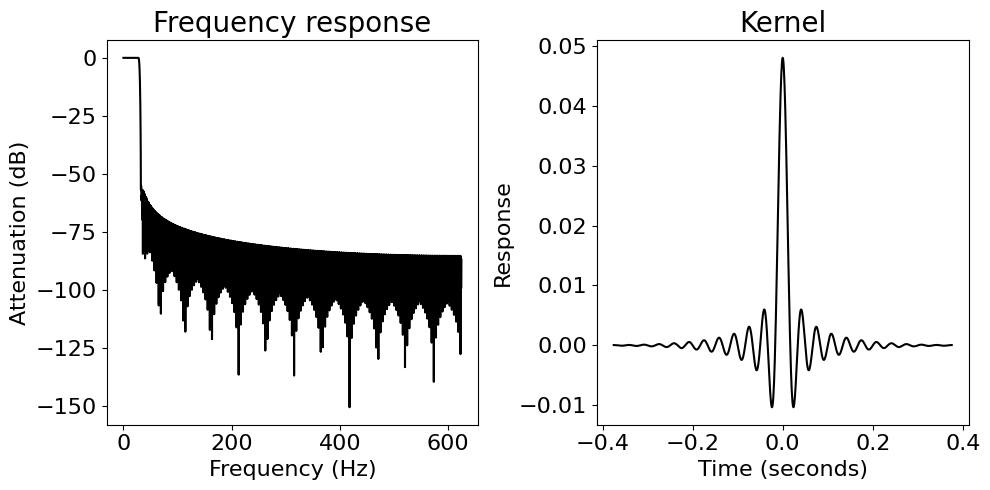

In [2]:
# Load data
sig = np.load('data/ca1.npy')
fs = 1250

# Filter settings
f_theta = (4, 10)
f_lowpass = 30
n_seconds_filter = .75

# Lowpass filter
sig_low = filter_signal(sig, fs, 'lowpass', f_lowpass, n_seconds=n_seconds_filter, 
                        remove_edges=False, plot_properties=True)

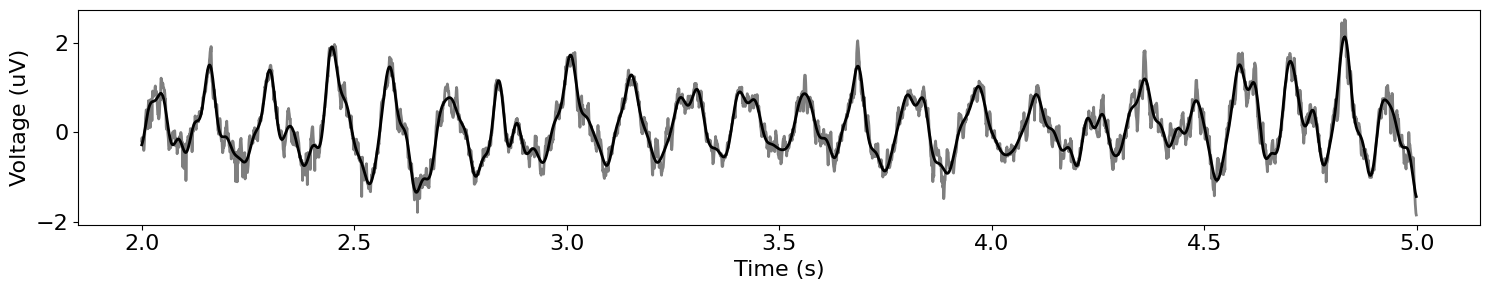

In [3]:
# Plot signal
times = np.arange(0, len(sig)/fs, 1/fs)
xlim = (2, 5)
tidx = np.logical_and(times >= xlim[0], times < xlim[1])

plot_time_series(times[tidx], [sig[tidx], sig_low[tidx]], colors=['k', 'k'], alpha=[.5, 1], lw=2)

## 1. Localize peaks and troughs

In order to characterize the oscillation, it is useful to know the precise times of peaks and
troughs. For one, this will allow us to compute the periods and rise-decay symmetries of the
individual cycles. To do this, the signal is first narrow-bandpass filtered in order to estimate
"zero-crossings." Then, in between these zero-crossings, the absolute maxima and minima are found
and labeled as the peaks and troughs, respectively.

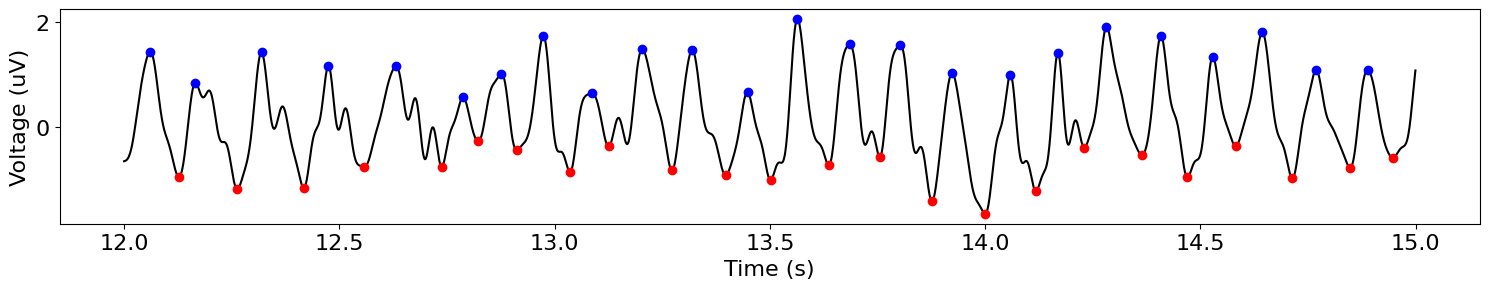

In [4]:
# Find peaks and troughs (this function also does the above)
peaks, troughs = find_extrema(sig_low, fs, f_theta,
                              filter_kwargs={'n_seconds': n_seconds_filter})

plot_cyclepoints_array(sig_low, fs, peaks=peaks, troughs=troughs, xlim=(12, 15))

## 2. Localize rise and decay midpoints

In addition to localizing the peaks and troughs of a cycle, we also want to get more information
about the rise and decay periods. For instance, these flanks may have deflections if the peaks or
troughs are particularly sharp. In order to gauge a dimension of this, we localize midpoints for
each of the rise and decay segments. These midpoints are defined as the times at which the voltage
crosses halfway between the adjacent peak and trough voltages. If this threshold is crossed
multiple times, then the median time is chosen as the flank midpoint. This is not perfect;
however, this is rare, and most of these cycles should be removed by burst detection.

Note: Plotting midpoints and extrema may also be performed using the dataframe output from 
`compute_features` with the `plot_cyclepoints` function.

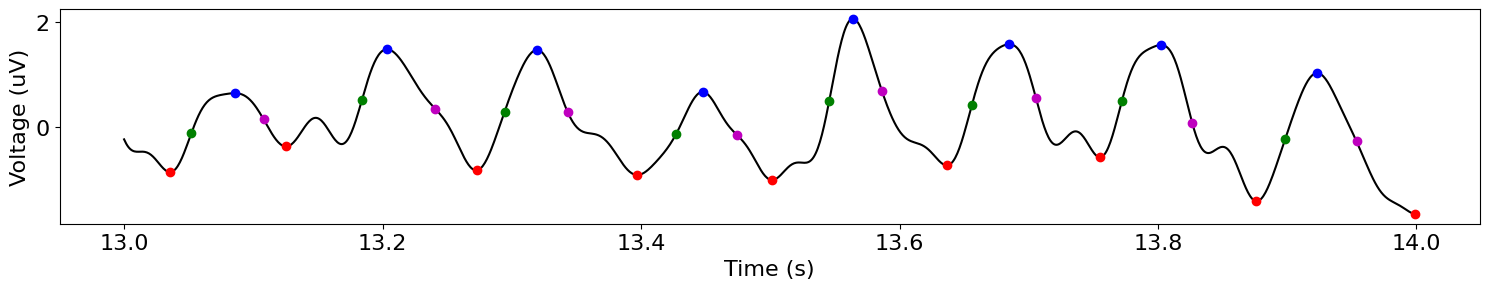

In [5]:
rises, decays = find_zerox(sig_low, peaks, troughs)

plot_cyclepoints_array(sig_low, fs, xlim=(13, 14), peaks=peaks, troughs=troughs,
                       rises=rises, decays=decays)

## 3. Compute features of each cycle

After these 4 points of each cycle are localized, we compute some simple statistics for each
cycle. The main cycle-by-cycle function, `compute_features`, returns a dataframe
containing cycle features and sample locations of cyclepoints in the signal. Each entry or row
in either dataframe is a cycle and each column is a property of that cycle (see table below). The
four main features are:

- amplitude (volt_amp) - average voltage change of the rise and decay
- period (period) - time between consecutive troughs (or peaks, if default is changed)
- rise-decay symmetry (time_rdsym) - fraction of the period in the rise period
- peak-trough symmetry (time_ptsym) - fraction of the period in the peak period

Note that a warning appears here because no burst detection parameters are provided. This is addressed
in the cells below.

In [6]:
# Compute bycycle features
df_features = compute_features(sig, fs, f_theta)

df_features[['amp_fraction', 'amp_consistency', 'period_consistency', 'monotonicity']]

/home/rph/Projects/spr2022/.env/lib/python3.8/site-packages/bycycle/features/features.py:122: UserWarning: 
            No burst detection thresholds are provided. This is not recommended. Please
            inspect your data and choose appropriate parameters for 'threshold_kwargs'.
            Default burst detection parameters are likely not well suited for your
            desired application.
            
  warnings.warn("""


,amp_fraction,amp_consistency,period_consistency,monotonicity
0,0.382479,NaN,NaN,0.625397
1,0.946581,0.741088,0.803571,0.639276
2,0.384615,0.702560,0.763393,0.636719
3,0.004274,0.630653,0.763393,0.589474
4,0.076923,0.637056,0.830409,0.652988
...,...,...,...,...
463,0.012821,0.764740,0.625000,0.592118
464,0.235043,0.633975,0.854167,0.629349
465,0.344017,0.850734,0.766871,0.649542
466,0.794872,0.673853,0.766871,0.812765



## 4. Determine parts of signal in oscillatory burst

Note above that the signal is segmented into cycles and the dataframe provides properties for each
segment of the signal. However, if no oscillation is apparent in the signal at a given time, the
properties for these "cycles" are meaningless. Therefore, it is useful to have a binary indicator
for each cycle that indicates whether the cycle being analyzed is truly part of an oscillatory
burst or not. Recently, significant interest has emerged in detecting bursts in signals and
analyzing their properties (see e.g. Feingold et al., PNAS, 2015). Nearly all efforts toward burst
detection relies on amplitude thresholds, but this can be disadvantageous because these algorithms
will behave very differently on signals where oscillations are common versus rare.

In our approach, we employ an alternative technique for burst detection. There are 3 thresholds
that need to be met in order for a cycle to be classified as part of an oscillatory burst.

1. amplitude consistency - consecutive rises and decays should be comparable in magnitude.
    - The amplitude consistency of a cycle is equal to the maximum relative difference between rises
  and decay amplitudes across all pairs of adjacent rises and decays that include one of the
  flanks in the cycle (3 pairs)
    - e.g. if a rise is 10mV and a decay is 7mV, then its amplitude consistency is 0.7.


2. period consistency - consecutive cycles should be comparable in duration
    - The period consistency is equal to the maximu relative difference between all pairs of
  adjacent periods that include the cycle of interest (2 pairs: current + previous cycles and
  current + next cycles)
    - e.g. if the previous, current, and next cycles have periods 60ms, 100ms, and 120ms,
  respectively, then the period consistency is min(60/100, 100/120) = 0.6.


3. monotonicity - the rise and decay flanks of the cycle should be mostly monotonic
    - The monotonicity is the fraction of samples that the instantaneous derivative (numpy.diff) is
  consistent with the direction of the flank.
    - e.g. if in the rise, the instantaneous derivative is 90% positive, and in the decay, the
  instantaneous derivative is 80% negative, then the monotonicity of the cycle would be 0.85
  ((0.9+0.8)/2)

Below, we load a simulated signal and then define 3 sets of thresholds ranging from liberal to
conservative.


In [7]:
from neurodsp.sim import sim_powerlaw, sim_cycle

# Simulation settings
np.random.seed(0)
n_seconds = 5
fs = 1000

# Simulate a dynamic periodic signal
sig_periodic = np.zeros(int(n_seconds * fs))

rdsyms = np.linspace(.2, .8, 25)

burst_inds = [(500, 1500), (2500, 3000), (3500, 4500)]

# For each burst, simulate on a cycle-by-cycle basis
rd_ind = 0

for burst_ind in burst_inds:

    for cyc_ind in range(burst_ind[0], burst_ind[1], 100):

        sig_periodic[cyc_ind:cyc_ind+100] = np.roll(sim_cycle(
            .1, fs, 'asine', rdsym=rdsyms[rd_ind]), 20)
        
        rd_ind += 1

# Simulate aperiodic component
sig_aperiodic = sim_powerlaw(n_seconds, fs, f_range=(2, None), exponent=-2, mean=0, variance=.1)

# Combine signals
sig = sig_periodic + sig_aperiodic


## Visualizing burst detection settings

Below, we visualize how the burst detector determined which cycles were part of an oscillatory
burst. The top plot shows a markup of the time series. The portions of the signal in red were
determined to be parts of bursts. Signals in black were not part of bursts. Magenta and cyan dots
denote detected peaks and troughs, respectively. Highlights indicate cycles marked as not part of
a burst because they did not meet certain thresholds:

- red highlight: amplitude consistency threshold violation
- yellow highlight: period consistency threshold violation
- green highlight: monotonicity threshold violation

The plots below show the relevant features for each cycle as well as the threshold (dotted lines), where we can see the highlights appear if the features went below the threshold.

Note there is an optional band "amplitude fraction" threshold. This is currently unused (set to 0),
but is present in case users want to add an amplitude threshold to this algorithm.

### Burst detection settings: too liberal

The following burst detection thresholds (defined in burst_kwargs) are too low, so some portions
of the signal that do not have much apparent oscillatory burst are still labeled as if they do.

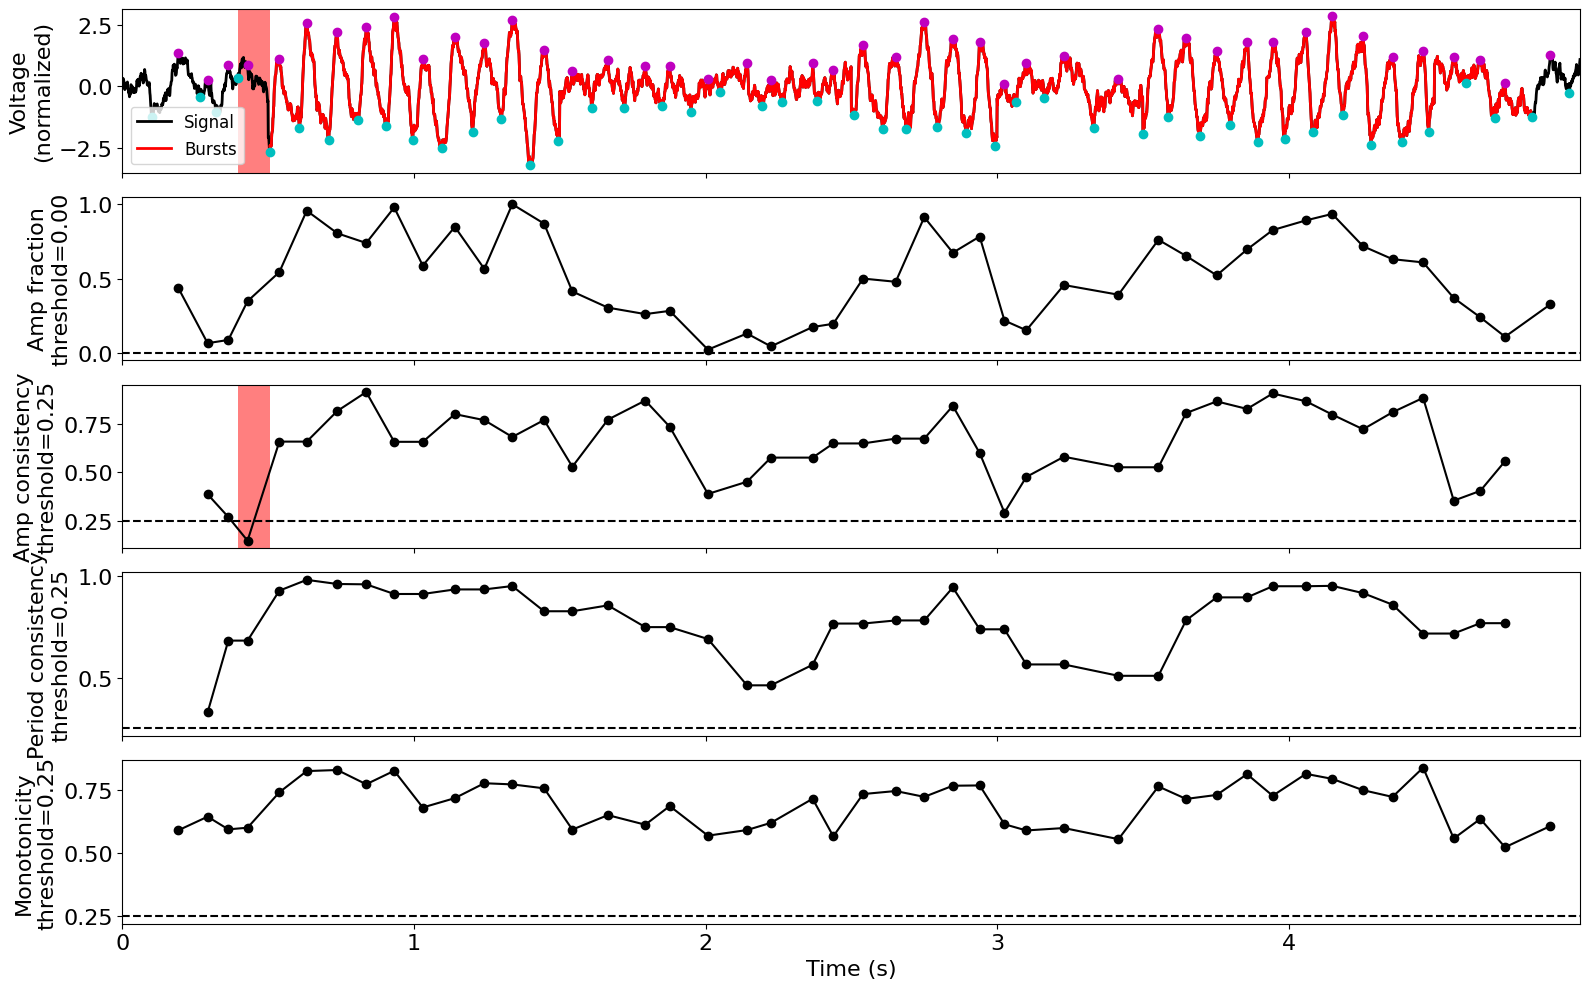

In [8]:
f_alpha = (8, 12)

threshold_kwargs = {'amp_fraction_threshold': 0,
                    'amp_consistency_threshold': .25,
                    'period_consistency_threshold': .25,
                    'monotonicity_threshold': .25,
                    'min_n_cycles': 3}

df_features = compute_features(sig, fs, f_alpha, threshold_kwargs=threshold_kwargs)

plot_burst_detect_summary(df_features, sig, fs, threshold_kwargs, figsize=(16, 2))

### Burst detection settings: too conservative

These new burst detection thresholds seem to be set too high (too strict) as the algorithm is not
able to detect the bursts that are present.

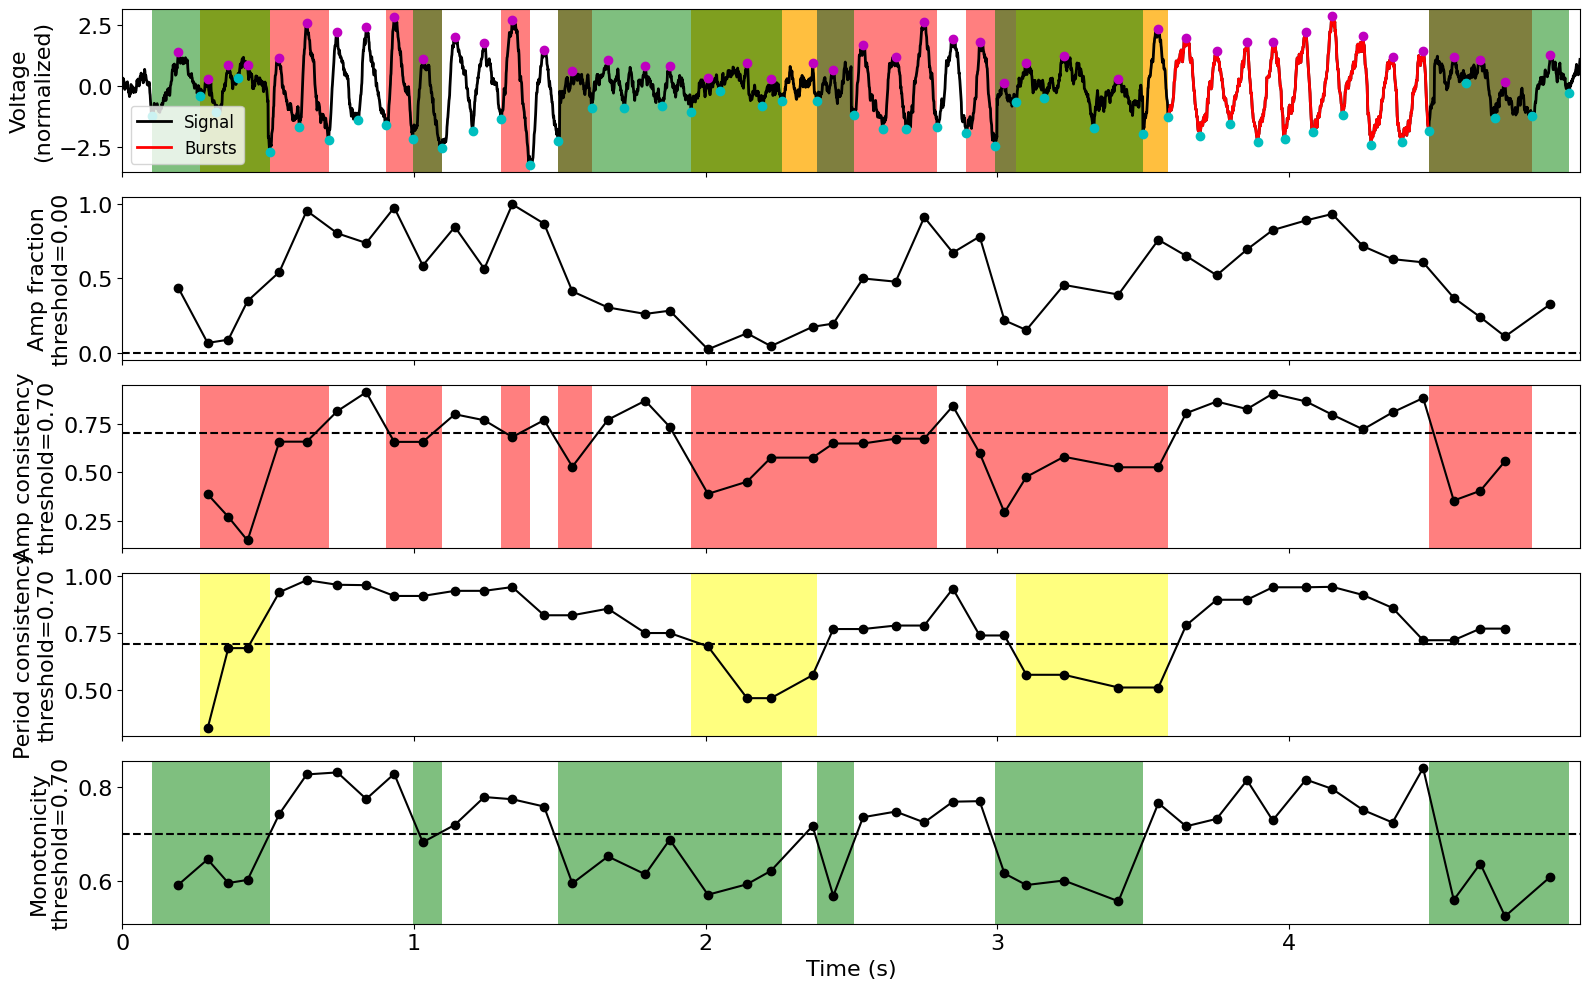

In [9]:

threshold_kwargs = {'amp_fraction_threshold': 0,
                    'amp_consistency_threshold': .7,
                    'period_consistency_threshold': .7,
                    'monotonicity_threshold': .7,
                    'min_n_cycles': 3}

df_features = compute_features(sig, fs, f_alpha, threshold_kwargs=threshold_kwargs)

plot_burst_detect_summary(df_features, sig, fs, threshold_kwargs, figsize=(16, 2))

### More appropriate burst detection thresholds

The conservative thresholds were then lowered, and we can see now that the algorithms correctly
identifies parts of the 3 bursting periods. Therefore, for a signal with this level of noise, we
expect these parameters to be pretty good.

Notice that adding a small amplitude fraction threshold (e.g. 0.3) helps remove some false
positives that may occur, like that around 1.5 seconds.

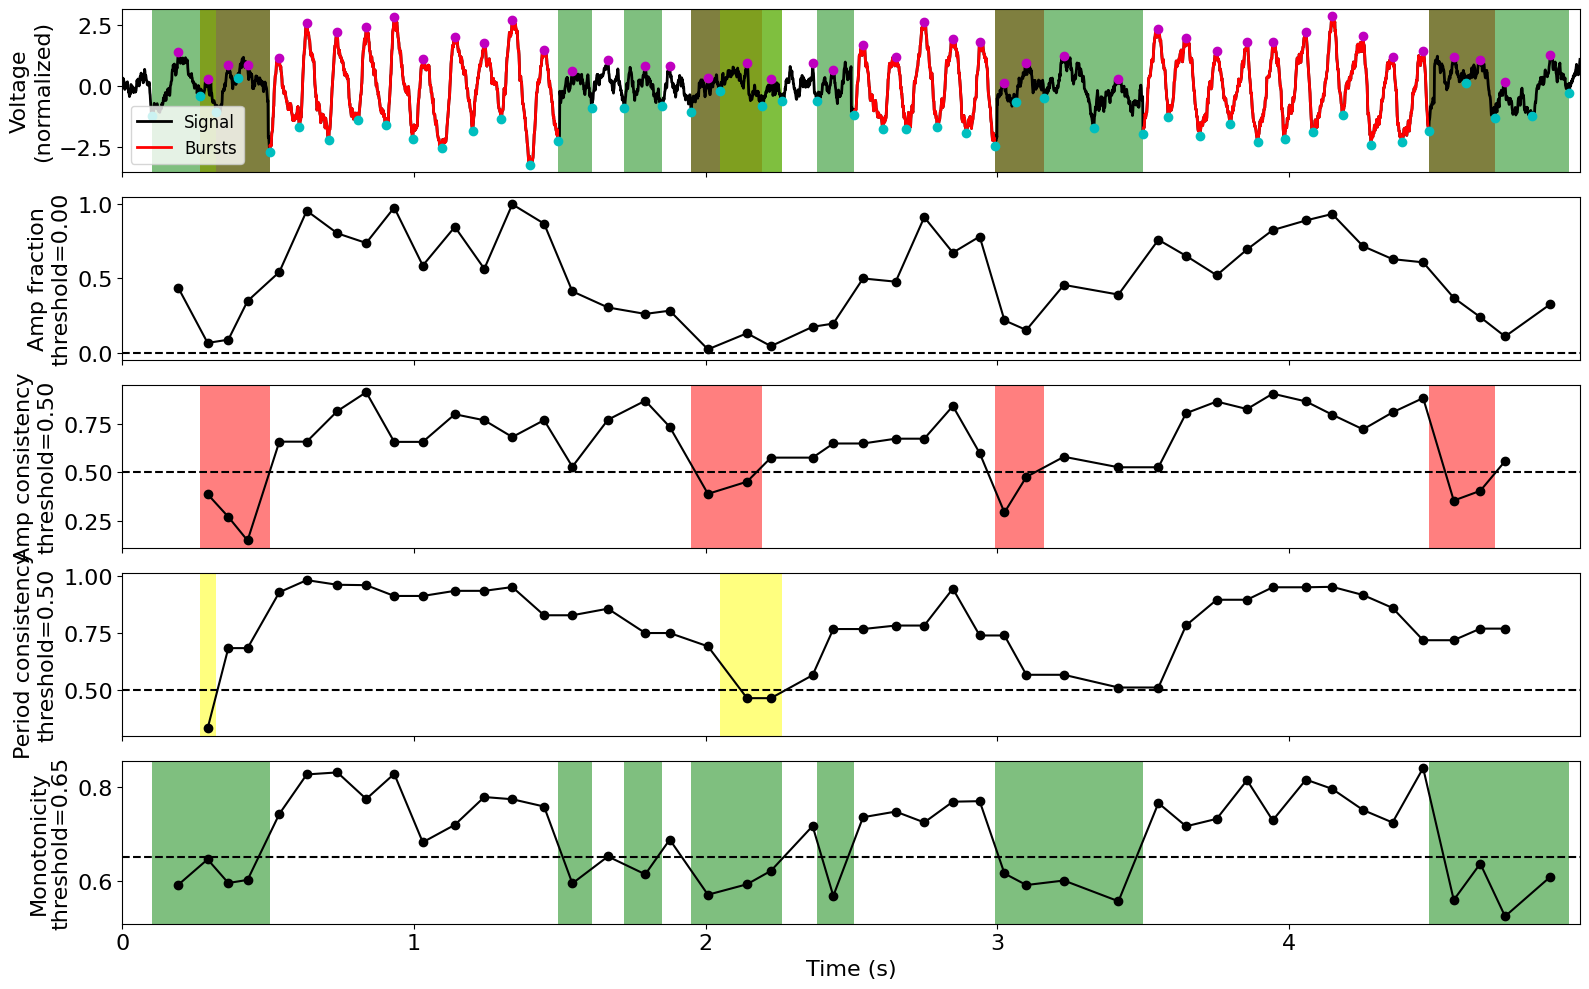

In [10]:

thresholds = {'amp_fraction_threshold': 0,
              'amp_consistency_threshold': .5,
              'period_consistency_threshold': .5,
              'monotonicity_threshold': .65,
              'min_n_cycles': 3}

df_features = compute_features(sig, fs, f_alpha, threshold_kwargs=thresholds)

plot_burst_detect_summary(df_features, sig, fs, thresholds, figsize=(16, 2))


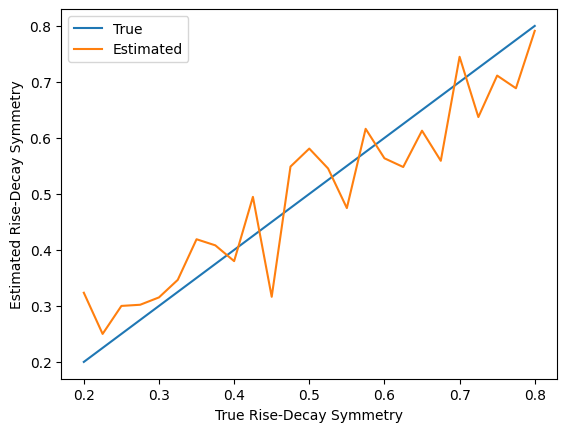

In [11]:
rdsyms_est = df_features['time_rdsym'].values
rdsyms_est = rdsyms_est[np.where(df_features['is_burst'])[0]]

plt.plot(rdsyms, rdsyms, label='True')
plt.plot(rdsyms, rdsyms_est, label='Estimated')

plt.xlabel('True Rise-Decay Symmetry')
plt.ylabel('Estimated Rise-Decay Symmetry')
plt.legend();